In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from pathlib import Path

import umap

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import HDBSCAN

from torchvision import transforms
from lightly.data import LightlyDataset
from lightly.data import SwaVCollateFunction
from lightly.loss import SwaVLoss
from lightly.models.modules.memory_bank import MemoryBankModule
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes
from lightly.models.utils import batch_shuffle, batch_unshuffle

from flash.core.optimizers import LARS, LinearWarmupCosineAnnealingLR

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, RawScoresOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from cnn.datasets import ExonetDataset, FeSequenceExonetDataset, FeExonetDataset
from cnn.utils import evaluate_cnn_model, inspect_images, recreate_video
from cnn.dataloaders import get_train_dataloaders, get_test_val_dataloader

/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


In [2]:
%load_ext autoreload
%autoreload 2

# SwAV

In [3]:
# ==========================================
# 1. Configuration (Thesis Hyperparameters)
# ==========================================
# Your Hardware Config
BATCH_SIZE = 128         # Fits comfortably on RTX 5090 (32GB VRAM)
NUM_WORKERS = 20         # Utilizing your i9-14900K cores
INPUT_SIZE = 224         # Global crop size
MAX_EPOCHS = 100

# Model Config
NUM_FTRS = 2048          # ResNet-50 feature dim (Use 512 if switching to ResNet-18)
PROJ_HIDDEN_DIM = 2048   # Hidden layer in projection head
PROJ_OUTPUT_DIM = 128    # The unit sphere dimension (standard for SwAV)
N_PROTOTYPES = 50        # Number of clusters (Set > expected classes, e.g., 50 for 10 classes)
QUEUE_LENGTH = 3840      # Critical for Single-GPU: Buffer stores ~30 batches of history

# Path to your extracted frames (folder containing images)
TRAIN_DATASET_PATH = '/home/luchocode/projects/tesis/data/selected_exoimages/train'
TEST_DATASET_PATH = '/home/luchocode/projects/tesis/data/selected_exoimages/test'
VAL_DATASET_PATH = '/home/luchocode/projects/tesis/data/selected_exoimages/val'

VAL_EMBEDDING_DIR = '/home/luchocode/projects/tesis/data/selected_exoimages/features/val'
TEST_EMBEDDING_DIR = '/home/luchocode/projects/tesis/data/selected_exoimages/features/test'

In [4]:
# ==========================================
# 2. The SwAV Lightning Module
# ==========================================
class SwAVModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # 1. Architecture (ResNet-50)
        # using 'weights' param instead of 'pretrained' (modern torchvision standard)
        resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        self.projection_head = SwaVProjectionHead(NUM_FTRS, PROJ_HIDDEN_DIM, PROJ_OUTPUT_DIM)
        self.prototypes = SwaVPrototypes(PROJ_OUTPUT_DIM, n_prototypes=N_PROTOTYPES)
        
        # 2. Loss
        self.criterion = SwaVLoss(sinkhorn_gather_distributed=False)

        # 3. FIFO Queue (Replaces Memory Bank)
        # We use register_buffer so it handles device placement (CPU/GPU) automatically
        self.queue_length = QUEUE_LENGTH
        self.register_buffer("queue", torch.zeros(QUEUE_LENGTH, PROJ_OUTPUT_DIM))
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
        self.use_queue = False # Will flip to True after epoch 15

    def forward(self, x):
        # Returns normalized FEATURES (on unit sphere)
        x = self.backbone(x).flatten(start_dim=1)
        x = self.projection_head(x)
        x = nn.functional.normalize(x, dim=1, p=2)
        return x

    def training_step(self, batch, batch_idx): 
        views, _, _ = batch
        high_resolution, low_resolution = views[:2], views[2:]
        self.prototypes.normalize()

        # 1. Forward Pass
        high_resolution_features = [self.forward(x) for x in high_resolution]
        low_resolution_features = [self.forward(x) for x in low_resolution]

        # 2. Get Logits (Scores) for current batch
        high_resolution_prototypes = [
            self.prototypes(x, self.current_epoch) for x in high_resolution_features
        ]
        low_resolution_prototypes = [
            self.prototypes(x, self.current_epoch) for x in low_resolution_features
        ]

        # 3. Handle Queue (FIFO Logic)
        queue_prototypes = None
        
        # Only use queue if it is enabled AND full
        if self.use_queue and len(self.queue) >= self.queue_length:
            with torch.no_grad():
                # Get logits for the cached queue features
                # clone().detach() is crucial to stop gradients flowing into the buffer
                q_logits = self.prototypes(self.queue.clone().detach(), self.current_epoch)
            queue_prototypes = [q_logits for _ in high_resolution_prototypes]
        
        # 4. Calculate Loss
        # SwaVLoss handles the queue argument internally (concatenation + slicing)
        loss = self.criterion(
            high_resolution_prototypes, 
            low_resolution_prototypes, 
            queue_prototypes
        )
        
        # 5. Update Queue (Pure FIFO)
        with torch.no_grad():
            # Crucial: Use ONLY the first global view to update.
            # This ensures the queue size remains consistent (multiples of batch_size).
            new_features = high_resolution_features[0].detach()
            batch_size = new_features.shape[0]
            ptr = int(self.queue_ptr)
            
            if ptr + batch_size <= self.queue_length:
                # self.queue = torch.cat([self.queue, new_features])
                self.queue[ptr : ptr + batch_size] = new_features
            else:
                # Remove oldest features, add newest features
                rem = self.queue_length - ptr
                self.queue[ptr : self.queue_length] = new_features[:rem]
                self.queue[0 : batch_size - rem] = new_features[rem:]
            
            # Update and wrap the pointer
            self.queue_ptr[0] = (ptr + batch_size) % self.queue_length

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        learning_rate = 4.8 * (BATCH_SIZE/4096)
        # We must exclude BatchNorm and Biases from Weight Decay and LARS adaptation.
        # If we decay these, the model collapses or becomes unstable.
        params = list(self.named_parameters())
        
        # Split params into "decay" and "no_decay" groups
        decay_params = []
        no_decay_params = []
        
        for name, param in params:
            # Skip params that don't require gradients
            if not param.requires_grad:
                continue
                
            # Check for Bias or BatchNorm in the name
            if "bias" in name or "bn" in name or "norm" in name:
                no_decay_params.append(param)
            else:
                decay_params.append(param)

        optim_groups = [
            {
                "params": decay_params,
                "weight_decay": 1e-6,
                "layer_adaptation": True, # LARS feature: adapt these layers
            },
            {
                "params": no_decay_params,
                "weight_decay": 0.0,      # Do NOT decay biases/bn
                "layer_adaptation": False, # Do NOT adapt biases/bn
            },
        ]

        # --- 3. Optimizer (LARS) ---
        optimizer = LARS(
            optim_groups,
            lr=learning_rate,
            momentum=0.9,
            trust_coefficient=0.001,
        )

        # --- 4. Scheduler (Warmup + Cosine) ---
        # SwAV uses a 10-epoch linear warmup to stabilize the prototypes
        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer,
            warmup_epochs=10, 
            max_epochs=MAX_EPOCHS,
            warmup_start_lr=0.0,
            eta_min=0.001 * learning_rate, # Final LR is small fraction of base
        )

        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]
    
    def on_train_epoch_start(self):
        # Enable queue after 15 epochs to ensure features are mature
        if self.current_epoch >= 15:
            self.use_queue = True

In [5]:
def train_swav_model(
    checkpoint_dir_folder,
    checkpoint_filename,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    img_dir=TRAIN_DATASET_PATH,
):
    """
    Trains a swav model returning the trainer and the path to the best model
    """
    # This function handles the complex "2 global + 6 local" crop logic automatically
    collate_fn = SwaVCollateFunction(
        crop_sizes=[224, 96],             # Global vs Local pixel sizes
        crop_counts=[2, 6],               # 2 Global views, 6 Local views
        crop_min_scales=[0.14, 0.05],     # Scaling factors (Zoom levels)
        crop_max_scales=[1.0, 0.14],
    )
    
    # LightlyDataset expects a folder of images (e.g., ./data/images/frame1.jpg)
    dataset = LightlyDataset(input_dir=img_dir)

    # load a dataloader
    dataloader = get_train_dataloaders(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    print(f"Training on: {torch.cuda.get_device_name(0)}")
    
    # Save the best model based on training loss
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=checkpoint_dir_folder,
        filename=checkpoint_filename,
        save_top_k=1,
        monitor="train_loss",
        mode="min",
        save_last=True,
        every_n_epochs=1
    )
    
    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator="gpu",
        devices=1,
        precision="16",
        callbacks=[checkpoint_callback],
        log_every_n_steps=10
    )
    
    model = SwAVModel()
    
    checkpoint_last_file = os.path.join(checkpoint_dir_folder, "last.ckpt")
    # Check if the file exists before trying to load it
    if os.path.exists(checkpoint_last_file):
        print("Crash detected! Resuming from last checkpoint...")
        resume_path = checkpoint_last_file
    else:
        print("No checkpoint found. Starting fresh training...")
        resume_path = None

    trainer.fit(model=model, train_dataloaders=dataloader, ckpt_path=resume_path)
    print(f"Training Complete. Model saved in '{checkpoint_dir_folder}'")

    return trainer, checkpoint_callback.best_model_path

In [6]:
swav_trainer, best_swav_model_path = train_swav_model(
    checkpoint_dir_folder="checkpoints/swav",
    checkpoint_filename="swav_resnet50_city_{epoch:02d}"
)

Using 16bit None Automatic Mixed Precision (AMP)
/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/pytorch_lightning/plugins/precision/native_amp.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training on: NVIDIA GeForce RTX 5090


You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory checkpoints/swav exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at checkpoints/swav/last.ckpt


Crash detected! Resuming from last checkpoint...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | backbone        | Sequential         | 23.5 M
1 | projection_head | SwaVProjectionHead | 4.5 M 
2 | prototypes      | SwaVPrototypes     | 6.5 K 
3 | criterion       | SwaVLoss           | 0     
-------------------------------------------------------
28.0 M    Trainable params
0         Non-trainable params
28.0 M    Total params
55.950    Total estimated model params size (MB)
Restored all states from the checkpoint file at checkpoints/swav/last.ckpt
`Trainer.fit` stopped: `max_epochs=100` reached.


Training Complete. Model saved in 'checkpoints/swav'


# Cluster images

In [7]:
def get_embeddings_and_images(model, dataloader, process_n_batch=100, device="cuda"):
    """
    Get embeddings and images from the model and dataloader.
    Args:
        model: The SwAVModel instance.
        dataloader: DataLoader for the evaluation dataset.
        process_n_batch: how many batches to process (default: 1000).
    """
    model.eval()
    model.to(device)
    targets = []
    embeddings = []
    images = []
    count_batches = 0
    with torch.no_grad():
        tqdm_dataloader = tqdm(dataloader, desc=f"Prediction", unit="batch")
        for batch in tqdm_dataloader:
            x, y, img_path = batch
            x = x.to(model.device)
            _embeddings = model.backbone(x).flatten(start_dim=1)
            _embeddings = torch.nn.functional.normalize(_embeddings, dim=1)
            embeddings.append(_embeddings.cpu().detach().numpy())
            images.append(np.array(img_path).reshape(-1,1)) # NCHW to NHWC
            targets.append(y.cpu().detach().numpy().reshape(-1,1))

            count_batches += 1
            if count_batches >= process_n_batch:
                break

    return np.vstack(embeddings), np.vstack(images), np.vstack(targets)


In [8]:
def generate_cluster_gallery(embeddings, images_path, img_base_dir, n_clusters=10, top_k=5):    
    # 2. Cluster
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(embeddings)
    distances = kmeans.transform(embeddings) # Distance to each centroid

    # 3. Plot Top-K for each cluster
    fig, axes = plt.subplots(n_clusters, top_k, figsize=(15, n_clusters * 2))
    
    for cluster_id in range(n_clusters):
        # Find indices of images in this cluster
        cluster_indices = np.where(labels == cluster_id)[0]
        # Sort by distance to this cluster's centroid
        cluster_distances = distances[cluster_indices, cluster_id]
        closest_indices = cluster_indices[np.argsort(cluster_distances)[:top_k]]
        
        for i, idx in enumerate(closest_indices):
            img_path = images_path[idx][0]
            img = Image.open(os.path.join(img_base_dir, img_path)).convert('RGB')
            axes[cluster_id, i].imshow(img)
            axes[cluster_id, i].axis('off')
            axes[cluster_id, i].set_title(f"{cluster_id}")

    plt.tight_layout()
    plt.savefig("cluster_results.png")

In [9]:
def get_inference_transforms():
    
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD  = [0.229, 0.224, 0.225]

    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

In [10]:
# trainer automatically auto-load the best weights from the previous run
eval_dataset = LightlyDataset(
    input_dir=VAL_DATASET_PATH,
    transform=get_inference_transforms()
)

eval_dataloader = get_test_val_dataloader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=NUM_WORKERS,
    shuffle=True
)

In [ ]:
# Load the best model
best_model = SwAVModel.load_from_checkpoint(best_swav_model_path)
embeddings, images_path, targets = get_embeddings_and_images(best_model, eval_dataloader, process_n_batch=753)

Prediction:  23%|███████████▉                                         | 320/1414 [00:26<01:21, 13.50batch/s]

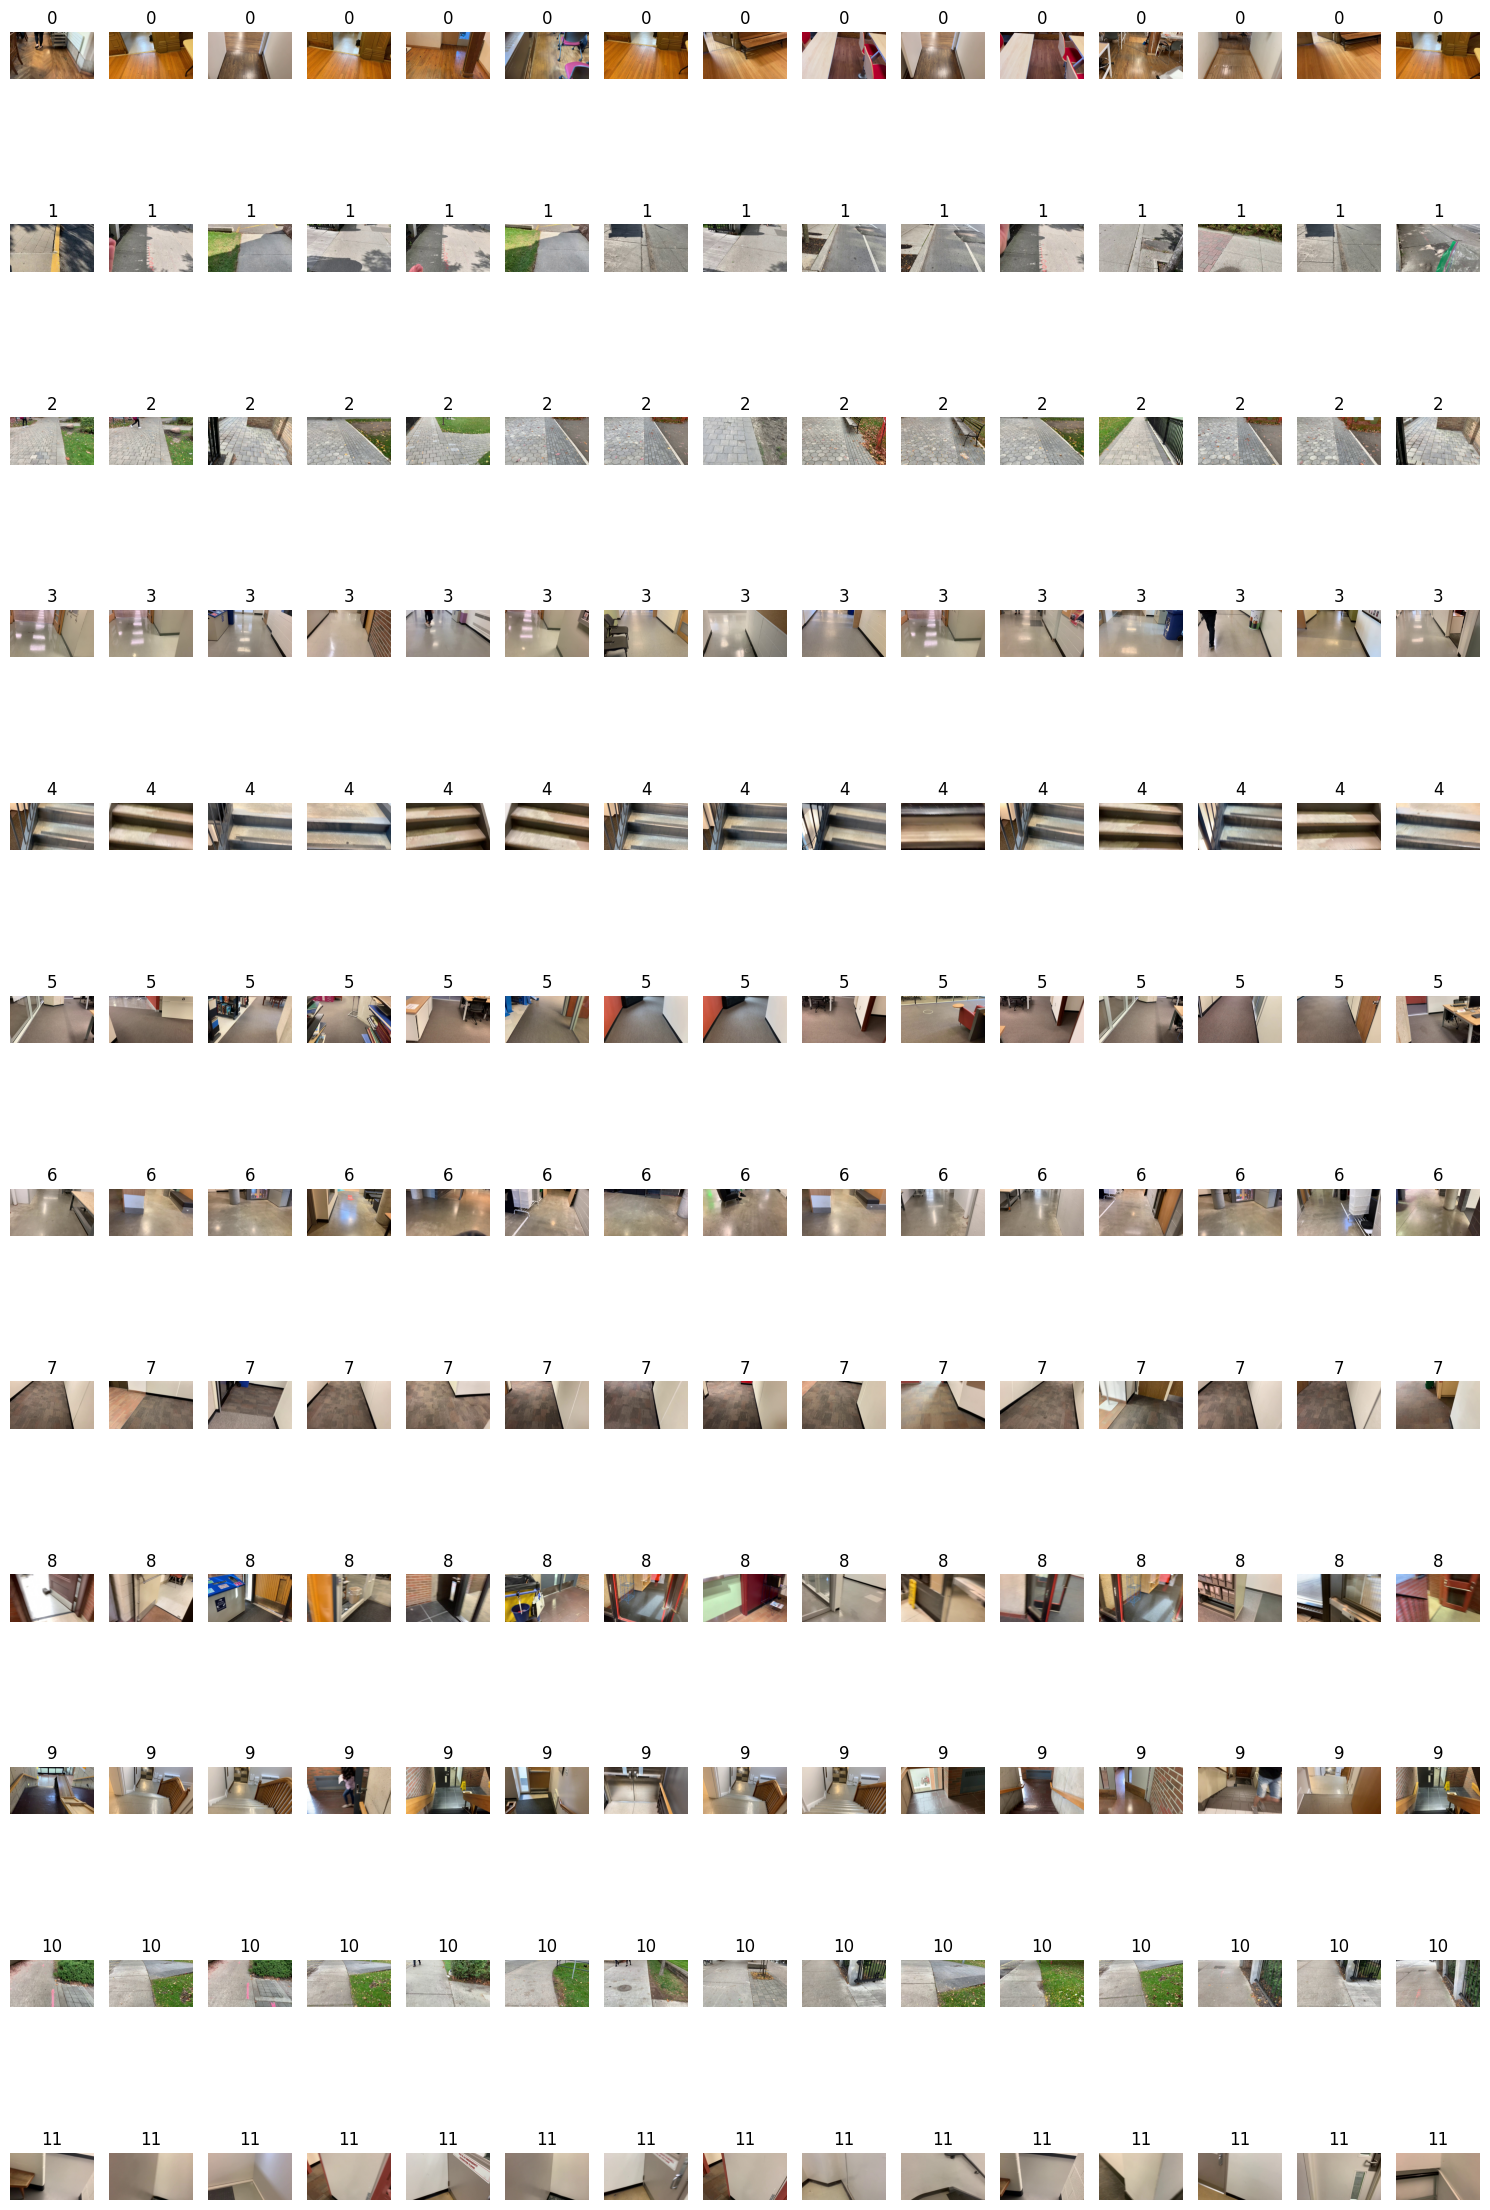

In [21]:
# plot cluster galleries
generate_cluster_gallery(embeddings, images_path, VAL_DATASET_PATH, n_clusters=12, top_k=15)

# Generate embeddings and persist them
The SwAV model trained will be used as embedding generator for training classifiers. The val and test images will be transformed to embeddings and persist them for a faster evaluation and training. They will not change in the training process.

In [22]:
def store_images_as_embeddings(
    df,
    base_dir_images,
    output_dir,
    swav_model_path
):
    model = SwAVModel.load_from_checkpoint(swav_model_path)
    model.eval()
    device = torch.accelerator.current_accelerator()
    model.to(device)

    embedding_transform = get_inference_transforms()

    dataset = ExonetDataset(
        df=df,
        base_dir=Path(base_dir_images),
        transform=embedding_transform,
        return_filepath=True
    )

    dataloader = get_test_val_dataloader(dataset, num_workers=10)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with torch.no_grad():
        tqdm_dataloader = tqdm(dataloader, desc="Generate/Store features", unit="batch")
        for batch_idx, (images, labels, file_paths) in enumerate(tqdm_dataloader):
            images = images.to(device)
            
            # 1. Get 2048-dim embedding from SwAV backbone
            features = model.backbone(images).flatten(start_dim=1)
            
            # 2. Save each feature vector to a .npy file
            features = features.cpu().numpy()
            for i, path in enumerate(file_paths):
                # check if class directory exists
                classname = labels[i]
                class_directory = os.path.join(output_dir, classname)
                if not os.path.exists(class_directory):
                    os.makedirs(class_directory)
                
                filename = path.replace(".jpg", ".npy")
                filepath = os.path.join(output_dir, filename)
                np.save(filepath, features[i])

In [23]:
# EXECUTE THIS CODE FOR NUMPY-PANDAS COMPATIBILITY BEFORE TO READ PICKLE OBJECTS
import sys
import numpy.core.numeric as _numeric
# Create a dummy module entry for the missing path
sys.modules['numpy._core.numeric'] = _numeric

In [24]:
# define dataframe 
df_val = pd.read_pickle('pickle/df_val.pkl')
df_test = pd.read_pickle('pickle/df_test.pkl')

In [27]:
# store images as embeddings for validation dataset
store_images_as_embeddings(df_val, VAL_DATASET_PATH, VAL_EMBEDDING_DIR, best_swav_model_path)

Generate/Store features: 100%|███████████████████████████████████████████████████| 1415/1415 [02:23<00:00,  9.85batch/s]


In [28]:
# store images as embeddings for testing dataset
store_images_as_embeddings(df_test, TEST_DATASET_PATH, TEST_EMBEDDING_DIR, best_swav_model_path)

Generate/Store features: 100%|█████████████████████████████████████████████████████| 753/753 [01:20<00:00,  9.32batch/s]


# Visualize distance between consecutive frames
Consecutive images should be closer from each other in the embedding space. When a transition starts, the distance between frames should increase until reach the next cluster. The transition could be visualized as a peak in a distance plot. 

In [46]:
def compute_similarity(sample_1, sample_2):
    # normalize
    s1 = nn.functional.normalize(sample_1, dim=1)
    s2 = nn.functional.normalize(sample_2, dim=1)
    # compute similarity
    return nn.functional.cosine_similarity(s1, s2).item()


def plot_consecutive_frames(df_video, embeddings_base_image_dir, base_image_dir):
    # --- PHASE 1: PRE-CALCULATE METRICS (Fast) ---
    dataset = FeExonetDataset(
        df_video,
        img_dir=Path(embeddings_base_image_dir),
        target_transform=None
    )

    results = [] # Use list for speed
    previous_frame_emb = None
    
    print("Computing distances...")
    # Iterate once to calculate all scores
    for i in range(len(dataset)):
        # Assuming dataset returns: embedding, label, image_name
        embedding, label, image_name = dataset[i]
        
        current_frame_emb = torch.from_numpy(embedding).unsqueeze(0)
        
        if previous_frame_emb is None:
            # First frame has no distance, use 0 or NaN
            score = 1.0
        else:
            score = compute_similarity(previous_frame_emb, current_frame_emb)
            # Ensure score is a standard float, not a tensor
            if isinstance(score, torch.Tensor):
                score = score.item()

        # Store in a clean dictionary
        results.append({
            'frame_idx': i,
            'score': score,
            'label': label,
            'image_name': image_name
        })
        
        previous_frame_emb = current_frame_emb

    # Create DataFrame (much easier to handle than mixed-type numpy array)
    df_metrics = pd.DataFrame(results)

    # --- PHASE 2: GENERATE VIDEO ---
    print("Generating video...")
    
    # Define a transform ONLY for display (No Normalization!)
    display_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 6
    out_video = None
    
    # Use 'Agg' backend to prevent windows popping up and save memory
    plt.switch_backend('Agg')

    for i, row in df_metrics.iterrows():
        # 1. Prepare Image
        img_path = os.path.join(base_image_dir, row['image_name'])
        
        # Load and crop/resize
        pil_img = Image.open(img_path).convert("RGB")
        pil_img = display_transform(pil_img)
        
        # Convert PIL -> Numpy -> BGR (for OpenCV)
        img = np.array(pil_img) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # 2. Build Plot
        fig, ax = plt.subplots(figsize=(10, 4)) # Smaller figure is faster
        
        # Slice data for the sliding window (e.g., show last 50 and next 50 frames)
        window_size = 100
        start = max(0, i - window_size)
        end = min(len(df_metrics), i + window_size)
        subset = df_metrics.iloc[start:end]

        # Draw the main line
        sns.lineplot(
            data=subset, x='frame_idx', y='score',
            color='grey', alpha=0.5, linewidth=1, ax=ax
        )
        
        # Draw the points (colored by label)
        sns.scatterplot(
            data=subset, x='frame_idx', y='score',
            hue='label', palette="tab10", s=20, ax=ax, legend=False
        )

        # Draw vertical line at CURRENT frame
        ax.axvline(x=i, color='red', linestyle='--', linewidth=2)
        
        # Fix X-axis to create "scrolling" effect
        ax.set_xlim(start, end)
        ax.set_ylim(0, 1.05) # Assuming cosine similarity 0-1
        ax.set_title("Frame Similarity Score")
        ax.grid(True, alpha=0.3)

        # 3. Convert Plot to Image
        fig.canvas.draw()
        
        # Get the RGBA buffer directly into a NumPy array
        img_plot = np.asarray(fig.canvas.buffer_rgba())        
        # Strip the Alpha channel (RGBA -> RGB) to match your expected shape
        img_plot = img_plot[:, :, :3]
        img_plot = cv2.cvtColor(img_plot, cv2.COLOR_RGB2BGR)
        
        # Clean up memory immediately
        plt.close(fig)

        # 4. Resize Plot to match Image Height
        h_img, w_img = img.shape[:2]
        h_plot, w_plot = img_plot.shape[:2]
        
        # Calculate aspect ratio to set correct width
        aspect_ratio = w_plot / h_plot
        new_plot_width = int(h_img * aspect_ratio)
        
        img_plot_resized = cv2.resize(img_plot, (new_plot_width, h_img))

        # 5. Concatenate
        final_image = cv2.hconcat([img, img_plot_resized])
        
        # Add Text overlay
        cv2.putText(
            final_image, 
            f"Dist: {row['score']:.3f}\nClass: {row['label']}",
            (30, 50), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.5, (0, 255, 0), 2
        )

        # 6. Write to Video
        if out_video is None:
            h_fin, w_fin = final_image.shape[:2]
            save_path = os.path.join('videos', 'video-embeddings.mp4')
            out_video = cv2.VideoWriter(save_path, fourcc, fps, (w_fin, h_fin))
        
        out_video.write(final_image)

        if i % 50 == 0:
            print(f"Processed frame {i}/{len(df_metrics)}")

    if out_video is not None:
        out_video.release()
    
    print("Video generation complete.")

In [20]:
plot_consecutive_frames(df_val[df_val["video"]=="IMG_03_4"].reset_index(drop=True), VAL_EMBEDDING_DIR, VAL_DATASET_PATH)

Computing distances...
Generating video...
Processed frame 0/8892
Processed frame 50/8892
Processed frame 100/8892
Processed frame 150/8892
Processed frame 200/8892
Processed frame 250/8892
Processed frame 300/8892
Processed frame 350/8892
Processed frame 400/8892
Processed frame 450/8892
Processed frame 500/8892
Processed frame 550/8892
Processed frame 600/8892
Processed frame 650/8892
Processed frame 700/8892
Processed frame 750/8892
Processed frame 800/8892
Processed frame 850/8892
Processed frame 900/8892
Processed frame 950/8892


KeyboardInterrupt: 

# Visualize embeddings using t-SNE

In [49]:
def visualize_embeddings(embeddings, labels, num_batches=20):
    """
    embeddings: Your trained SwAV ResNet model
    labels: Your validation dataloader
    num_batches: Limit how much data we use (t-SNE is slow on >10k points)
    """
    
    print(f"Data shape: {embeddings.shape}")

    # --- Step 2: Pre-process with PCA (Optional but Recommended) ---
    # t-SNE struggles with 2048 dimensions. Reducing to 50 first is standard practice.
    print("Reducing dimensions with PCA first...")
    pca = PCA(n_components=50)
    X = pca.fit_transform(embeddings)
    # print("Reducing dimensions with UMAP first...")
    # reducer = umap.UMAP(n_components=50, n_neighbors=15, min_dist=0.0)
    # X = reducer.fit_transform(embeddings)

    # --- Step 3: Run t-SNE ---
    # perplexity: How many neighbors to look at. 30-50 is standard.
    print("Running t-SNE (this might take a moment)...")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=5000, random_state=42)
    X_embedded = tsne.fit_transform(X) # Shape: [N, 2]

    # --- Step 4: Plotting ---
    print("Plotting...")
    plt.figure(figsize=(10, 8))
    
    # Define your class names map for the legend
    # label_map = {0: "Ground", 1: "Stairs", 2: "Wall", ...}
    
    # Use Seaborn for a pretty scatterplot
    sns.scatterplot(
        x=X_embedded[:, 0], 
        y=X_embedded[:, 1], 
        hue=labels[:,0],
        palette="tab10", # distinct colors
        legend="full",
        alpha=0.7        # transparency
    )
    
    plt.title("SwAV Embedding Space (t-SNE)")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()

Data shape: (5000, 2048)
Reducing dimensions with PCA first...
Running t-SNE (this might take a moment)...
Plotting...


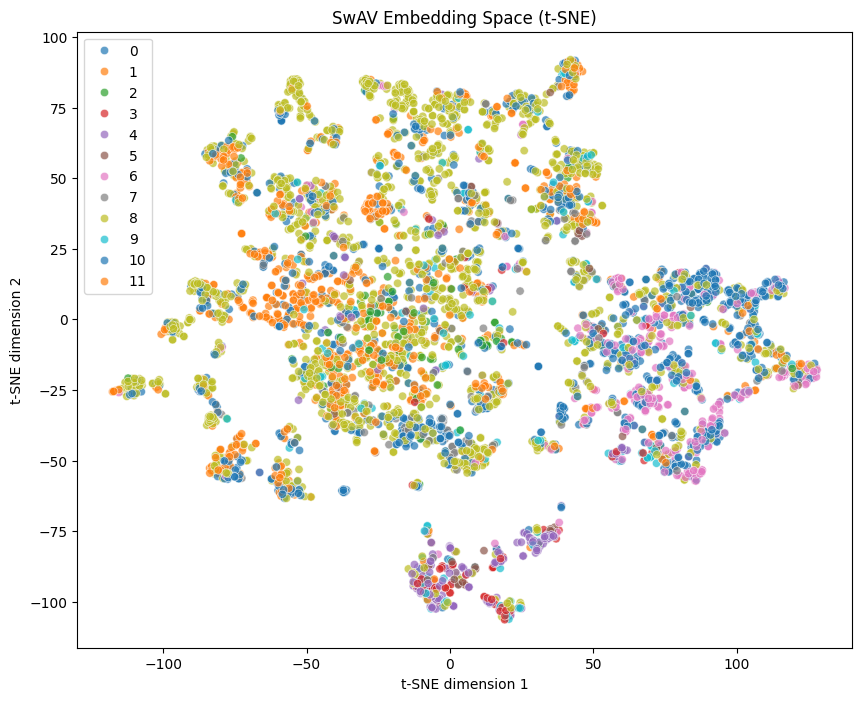

In [50]:
%matplotlib inline
visualize_embeddings(embeddings[:5000], targets[:5000])

In [54]:
def get_k_means_labels(embeddings, n_clusters):
    pca = PCA(n_components=50)
    X = pca.fit_transform(embeddings)
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(X)
    return labels

Data shape: (5000, 2048)
Reducing dimensions with PCA first...
Running t-SNE (this might take a moment)...
Plotting...


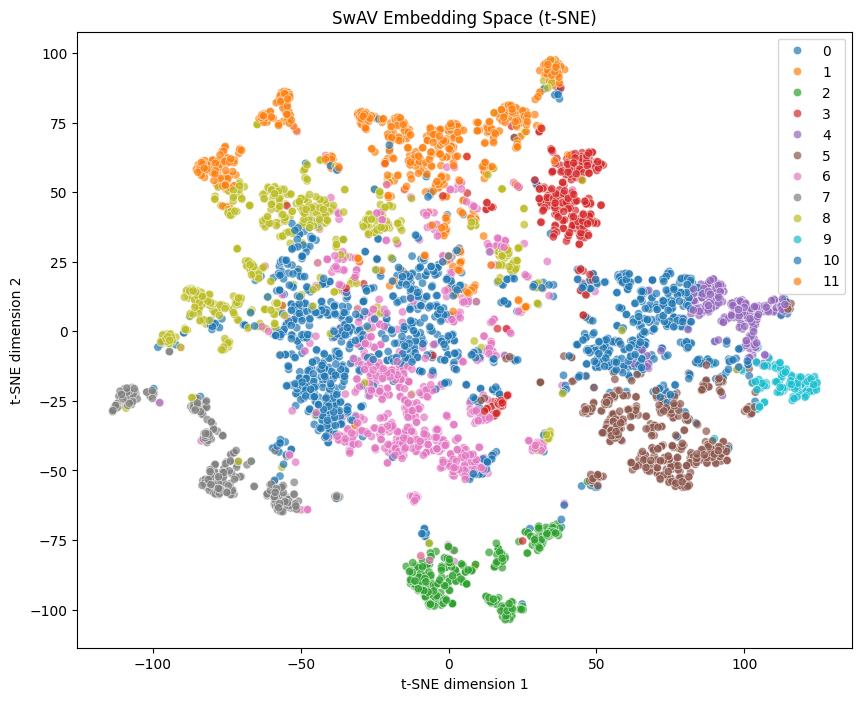

In [55]:
k_means_labels = get_k_means_labels(embeddings[:5000], n_clusters=12)
visualize_embeddings(embeddings[:5000], k_means_labels.reshape(-1,1))

Data shape: (5000, 2048)
Reducing dimensions with PCA first...
Running t-SNE (this might take a moment)...
Plotting...


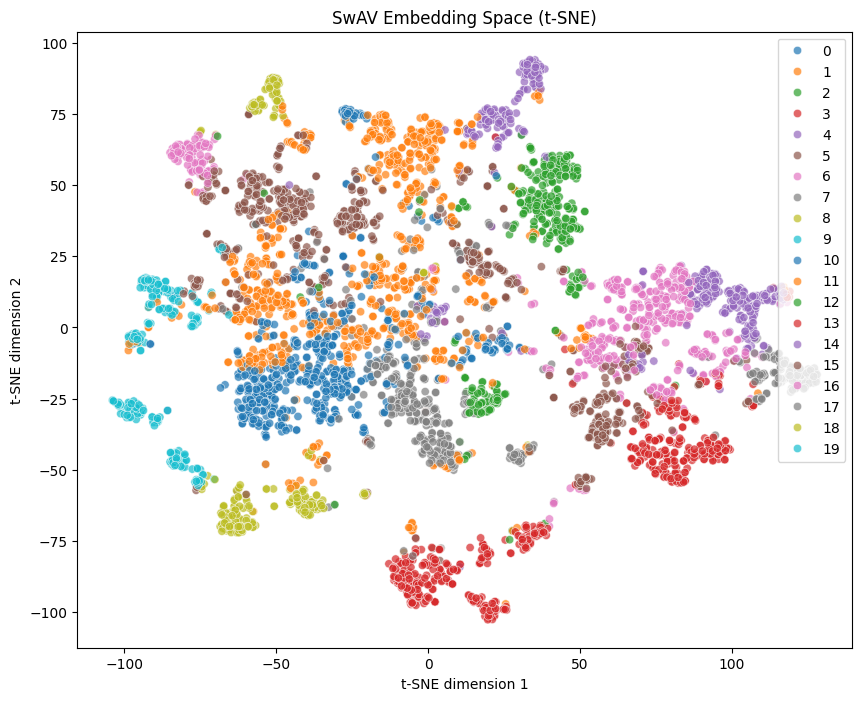

In [56]:
k_means_labels = get_k_means_labels(embeddings[:5000], n_clusters=20)
visualize_embeddings(embeddings[:5000], k_means_labels.reshape(-1,1))

Data shape: (10000, 2048)
Reducing dimensions with PCA first...
Running t-SNE (this might take a moment)...
Plotting...


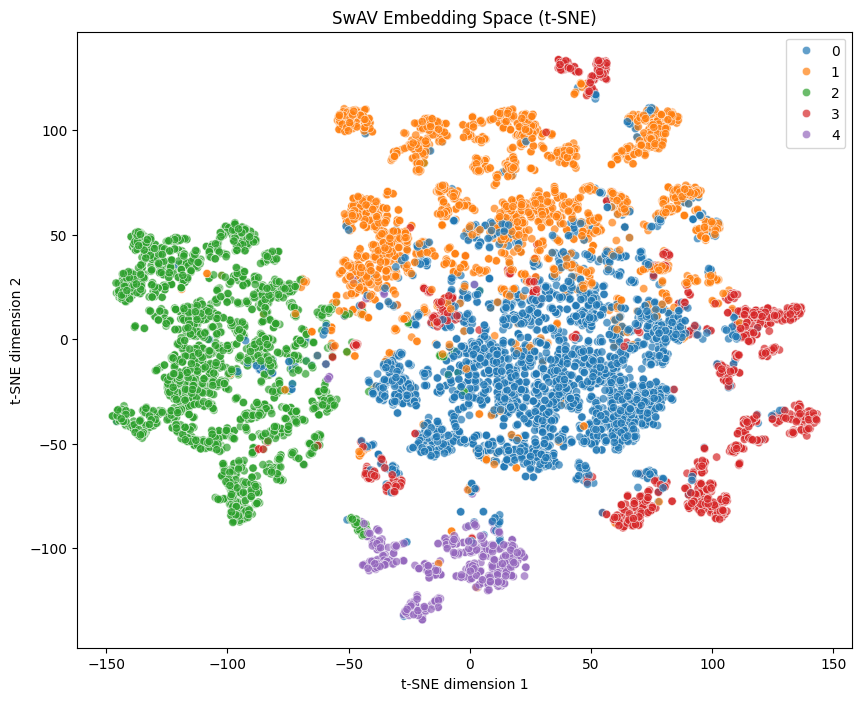

In [69]:
k_means_labels = get_k_means_labels(embeddings[:10000], n_clusters=5)
visualize_embeddings(embeddings[:10000], k_means_labels.reshape(-1,1))

In [66]:
def get_hdbscan_labels(embeddings):
    print("Reducing dimensions...")
    pca = PCA(n_components=50)
    X_reduced = pca.fit_transform(embeddings)
    
    hdbscan_model = HDBSCAN(min_cluster_size=60, min_samples=10, metric='euclidean')
    labels = hdbscan_model.fit_predict(X_reduced)

    return labels

Reducing dimensions...
Data shape: (10000, 2048)
Reducing dimensions with PCA first...
Running t-SNE (this might take a moment)...
Plotting...


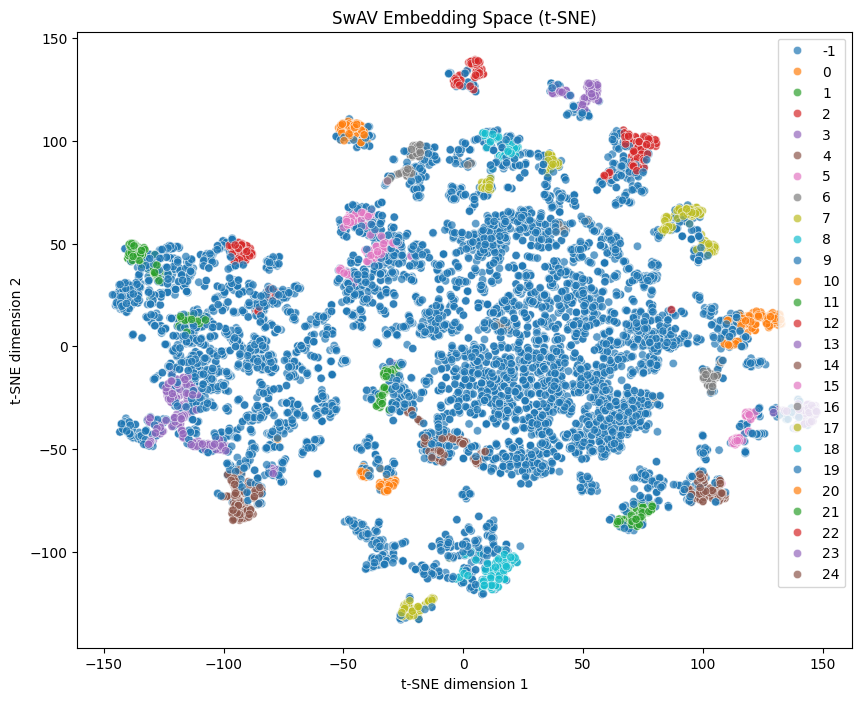

In [68]:
k_means_labels = get_hdbscan_labels(embeddings[:10000])
visualize_embeddings(embeddings[:10000], k_means_labels.reshape(-1,1))

Data shape: (10000, 2048)
Reducing dimensions with PCA first...
Running t-SNE (this might take a moment)...
Plotting...


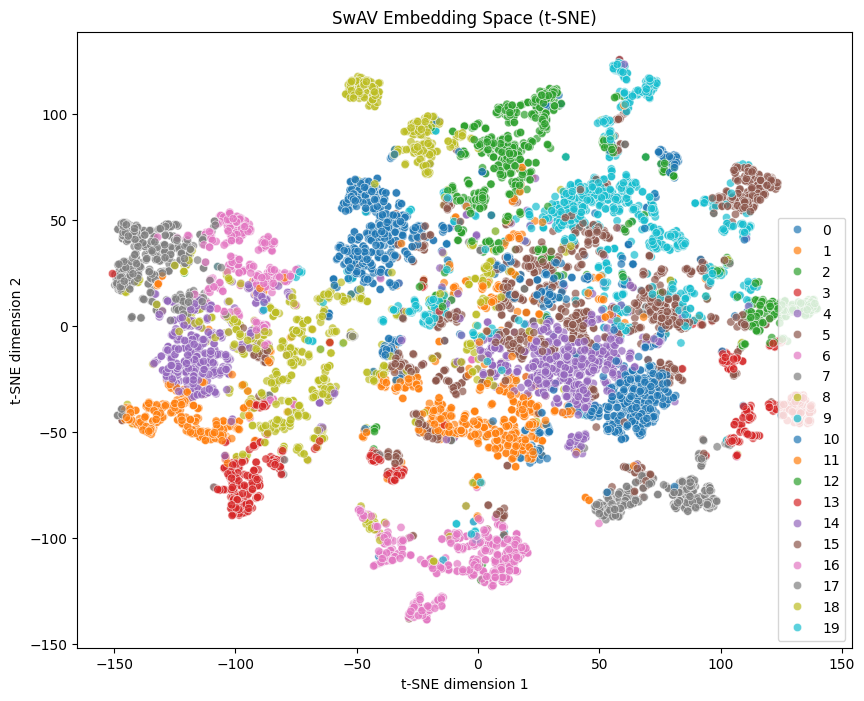

In [70]:
k_means_labels = get_k_means_labels(embeddings[:10000], n_clusters=20)
visualize_embeddings(embeddings[:10000], k_means_labels.reshape(-1,1))

# Cluster audit
Find 50 cluster centers using K-means. Sample 15 images from each cluster and assign a name to this cluster. The allowed labels are:
- LG
- IS
- DS
- DOOR
- WALL
- OTHER

In [80]:
a = np.array([1,2,3,4,4,4,2,0])
np.argwhere(a==4).reshape(-1)

array([3, 4, 5])

In [ ]:
def audit_cluster(embeddings, image_paths, base_image_dir, n_samples=15, n_clusters=50):
    # get cluster labels using k-means
    print("Finding cluster centers")
    labels = get_k_means_labels(embeddings, n_clusters=n_clusters)
    unique_labels = np.unique(labels)

    # sample images of each label
    print("Generating plot")
    fig, axes = plt.subplots(n_clusters, n_samples, figsize=(15, n_clusters * 2))
    for label in labels:
        
        total_samples = np.argwhere(labels==label).reshape(-1)
        if len(total_samples) < n_samples:
            samples_idx = total_samples
        else:
            samples_idx = np.random.choice(total_samples, size=n_samples, replace=False)

        for i, idx in enumerate(samples_idx):
            img_path = image_paths[idx][0]
            img = Image.open(os.path.join(base_image_dir, img_path)).convert("RGB")
            axes[label, i].imshow(img)
            axes[label, i].axis('off')
            axes[label, i].set_title(f"{label}")

    plt.tight_layout()
    plt.savefig("cluster_audit.png")

audit_cluster(embeddings[:10000], images_path[:10000], VAL_DATASET_PATH)

Finding cluster centers


# Transfer learning using SwAV pre-trained model


In [82]:
class SwavBackbone(pl.LightningModule):
    def __init__(
        self, 
        backbone,
        num_classes,
        in_features,
        dropout_p=0.5,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=['backbone'])

        # define layers
        self.backbone = backbone.eval()
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features, num_classes)
        )

        # freeze the backbone params
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # define criterion
        self.criterion = nn.CrossEntropyLoss()

        self.validation_step_outputs = {
            "preds": [],
            "trues": []
        }

        self.training_step_outputs = {
            "preds": [],
            "trues": []
        }

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1) # similar to use nn.Flatten()
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        logits = self.forward(inputs)

        loss = self.criterion(logits, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        preds = logits.argmax(dim=1)

        self.training_step_outputs["preds"].append(preds)
        self.training_step_outputs["trues"].append(labels)
        
        return loss

    def on_train_epoch_end(self, ):
        all_preds = torch.stack(self.training_step_outputs["preds"], dim=0)
        all_labels = torch.stack(self.training_step_outputs["trues"], dim=0)

        acc = (all_preds == all_labels).count_nonzero().item() / all_preds.shape[0]
        self.log_dict({'train_acc': acc})

        self.training_step_outputs["preds"].clear()
        self.training_step_outputs["trues"].clear()

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        logits = self.forward(inputs)

        loss = self.criterion(logits, labels)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        preds = logits.argmax(dim=1)
        self.validation_step_outputs["preds"].append(preds)
        self.validation_step_outputs["trues"].append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.stack(self.validation_step_outputs["preds"], dim=0)
        all_labels = torch.stack(self.validation_step_outputs["trues"], dim=0)

        acc = (all_preds == all_labels).count_nonzero().item() / all_preds.shape[0]
        self.log_dict({'val_acc': acc})

        self.validation_step_outputs["preds"].clear()
        self.validation_step_outputs["trues"].clear()
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=0.3,
            momentum=0.9,
            weight_decay=1e-6
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs,
            eta_min=0.0
        )
        return [optimizer], [scheduler]

In [83]:
def train_transfer_model(
    transfer_model: SwavBackbone,
    train_dataframe: pd.DataFrame,
    val_dataframe: pd.DataFrame,
    img_dir: str,
    checkpoints_dir: str,
    checkpoint_filename: str,
    transform,
    target_transform,
    val_transform
):
    # define dataset
    dataset = ExonetDataset(
        df=train_dataframe,
        base_dir=Path(img_dir),
        transform=transform,
        target_transform=target_transform
    )

    # define val dataset
    val_dataset = ExonetDataset(
        df=val_dataframe,
        base_dir=Path(img_dir),
        transform=val_transform,
        target_transform=target_transform
    )

    # define dataloader
    dataloader = get_train_dataloaders(dataset, batch_size=256, num_workers=15)

    # define val dataloader
    val_dataloader = get_test_val_dataloader(val_dataset, batch_size=256, num_workers=5, drop_last=True)

    # define checkpoint callback
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=checkpoints_dir,
        filename=checkpoint_filename + "_{epoch:02d}",
        save_top_k=1,
        monitor="train_loss",
        mode="min",
        save_last=True,
        every_n_epochs=1
    )
    
    # define trainer
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        accelerator="gpu",
        devices=1,
        precision="16",
        callbacks=[checkpoint_callback],
        log_every_n_steps=10
    )

    # Check if the file exists before trying to load it
    checkpoint_last_file = f"{checkpoints_dir}/last.ckpt"
    if os.path.exists(checkpoint_last_file):
        print("Crash detected! Resuming from last checkpoint...")
        resume_path = checkpoint_last_file
    else:
        print("No checkpoint found. Starting fresh training...")
        resume_path = None
    
    trainer.fit(model=transfer_model, train_dataloaders=dataloader, val_dataloaders=val_dataloader, ckpt_path=resume_path)
    print("Training Complete. Model saved in 'checkpoints_val_epochs/'")

    return trainer, checkpoint_callback.best_model_path

In [84]:
# load best model
best_model = SwAVModel.load_from_checkpoint(best_swav_model_path)

# define transfer learning model
transfer_model = SwavBackbone(
    backbone=best_model.backbone,
    num_classes=12,
    in_features=NUM_FTRS,
    dropout_p=0.5
)

# define label transform
class_names = df_val["class"].unique()
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(class_names)
target_transform = label_encoder.transform

In [85]:
def get_transfer_transforms(split):
    # Standard ImageNet statistics (Use these if your SwAV was trained on ImageNet)
    # If you pre-trained SwAV on your OWN data, calculate the mean/std of that dataset!
    MEAN = [0.485, 0.456, 0.406]
    STD  = [0.229, 0.224, 0.225]

    if split == 'train':
        return transforms.Compose([
            # 1. Random Resized Crop: The most important augmentation
            # Crops a random piece of the image (8% to 100% of area) and resizes to 224
            transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),
            
            # 2. Random Flip: Doubles your dataset variations
            transforms.RandomHorizontalFlip(),
            
            # 3. (Optional) Mild Color Jitter
            # Only use if color isn't a strict diagnostic feature
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD)
        ])
    
    elif split == 'val' or split == 'test':
        return transforms.Compose([
            # 1. Resize to 256 (larger than 224)
            transforms.Resize(256),
            
            # 2. Take the center square
            transforms.CenterCrop(224),
            
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD)
        ])

In [ ]:
# train model
_, best_transfer_model_path = train_transfer_model(
    transfer_model=transfer_model,
    train_dataframe=df_val[df_val['video']!='IMG_10_1'].reset_index(drop=True),
    val_dataframe=df_val[df_val['video']=='IMG_10_1'].reset_index(drop=True),
    img_dir=VAL_DATASET_PATH,
    checkpoints_dir='checkpoints/transfer_swav',
    checkpoint_filename='transfer_learning_swav_resnet50',
    transform=get_transfer_transforms(split='train'),
    target_transform=target_transform,
    val_transform=get_transfer_transforms(split='val')
)


Using 16bit None Automatic Mixed Precision (AMP)
/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/pytorch_lightning/plugins/precision/native_amp.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbo

No checkpoint found. Starting fresh training...


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Evaluation: 100%|██████████████████████████████████████████████████████| 753/753 [09:20<00:00,  1.34batch/s]


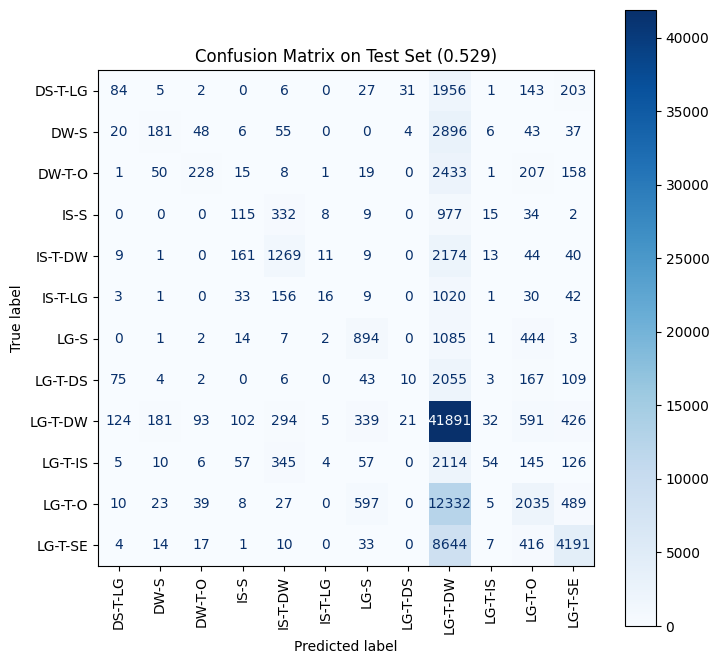

In [8]:
# read test dataframe
df_test = pd.read_pickle('pickle/df_test.pkl')

# create dataset
test_dataset = ExonetDataset(
    df=df_test,
    base_dir=Path(TEST_DATASET_PATH),
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    target_transform=target_transform
)

# define test dataloader
test_dataloader = get_test_val_dataloader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=1
)

# load best model
transfer_best_model = SwavBackbone.load_from_checkpoint(
    "checkpoints_sample_train/transfer_learning_swav_resnet50_epoch=91.ckpt",
    backbone=best_model.backbone,
    num_classes=12,
    in_features=NUM_FTRS,
    dropout_p=0.5
)
# show confusion matrix for test dataset
preds, labels = evaluate_cnn_model(
    model=transfer_best_model,
    loader=test_dataloader,
    device=transfer_best_model.device,
    class_names=label_encoder.classes_,
    title="Test"
)

Total samples: 12332
Filtered images: torch.Size([15, 3, 224, 224])
Heatmaps' shape: torch.Size([15, 1, 224, 224])


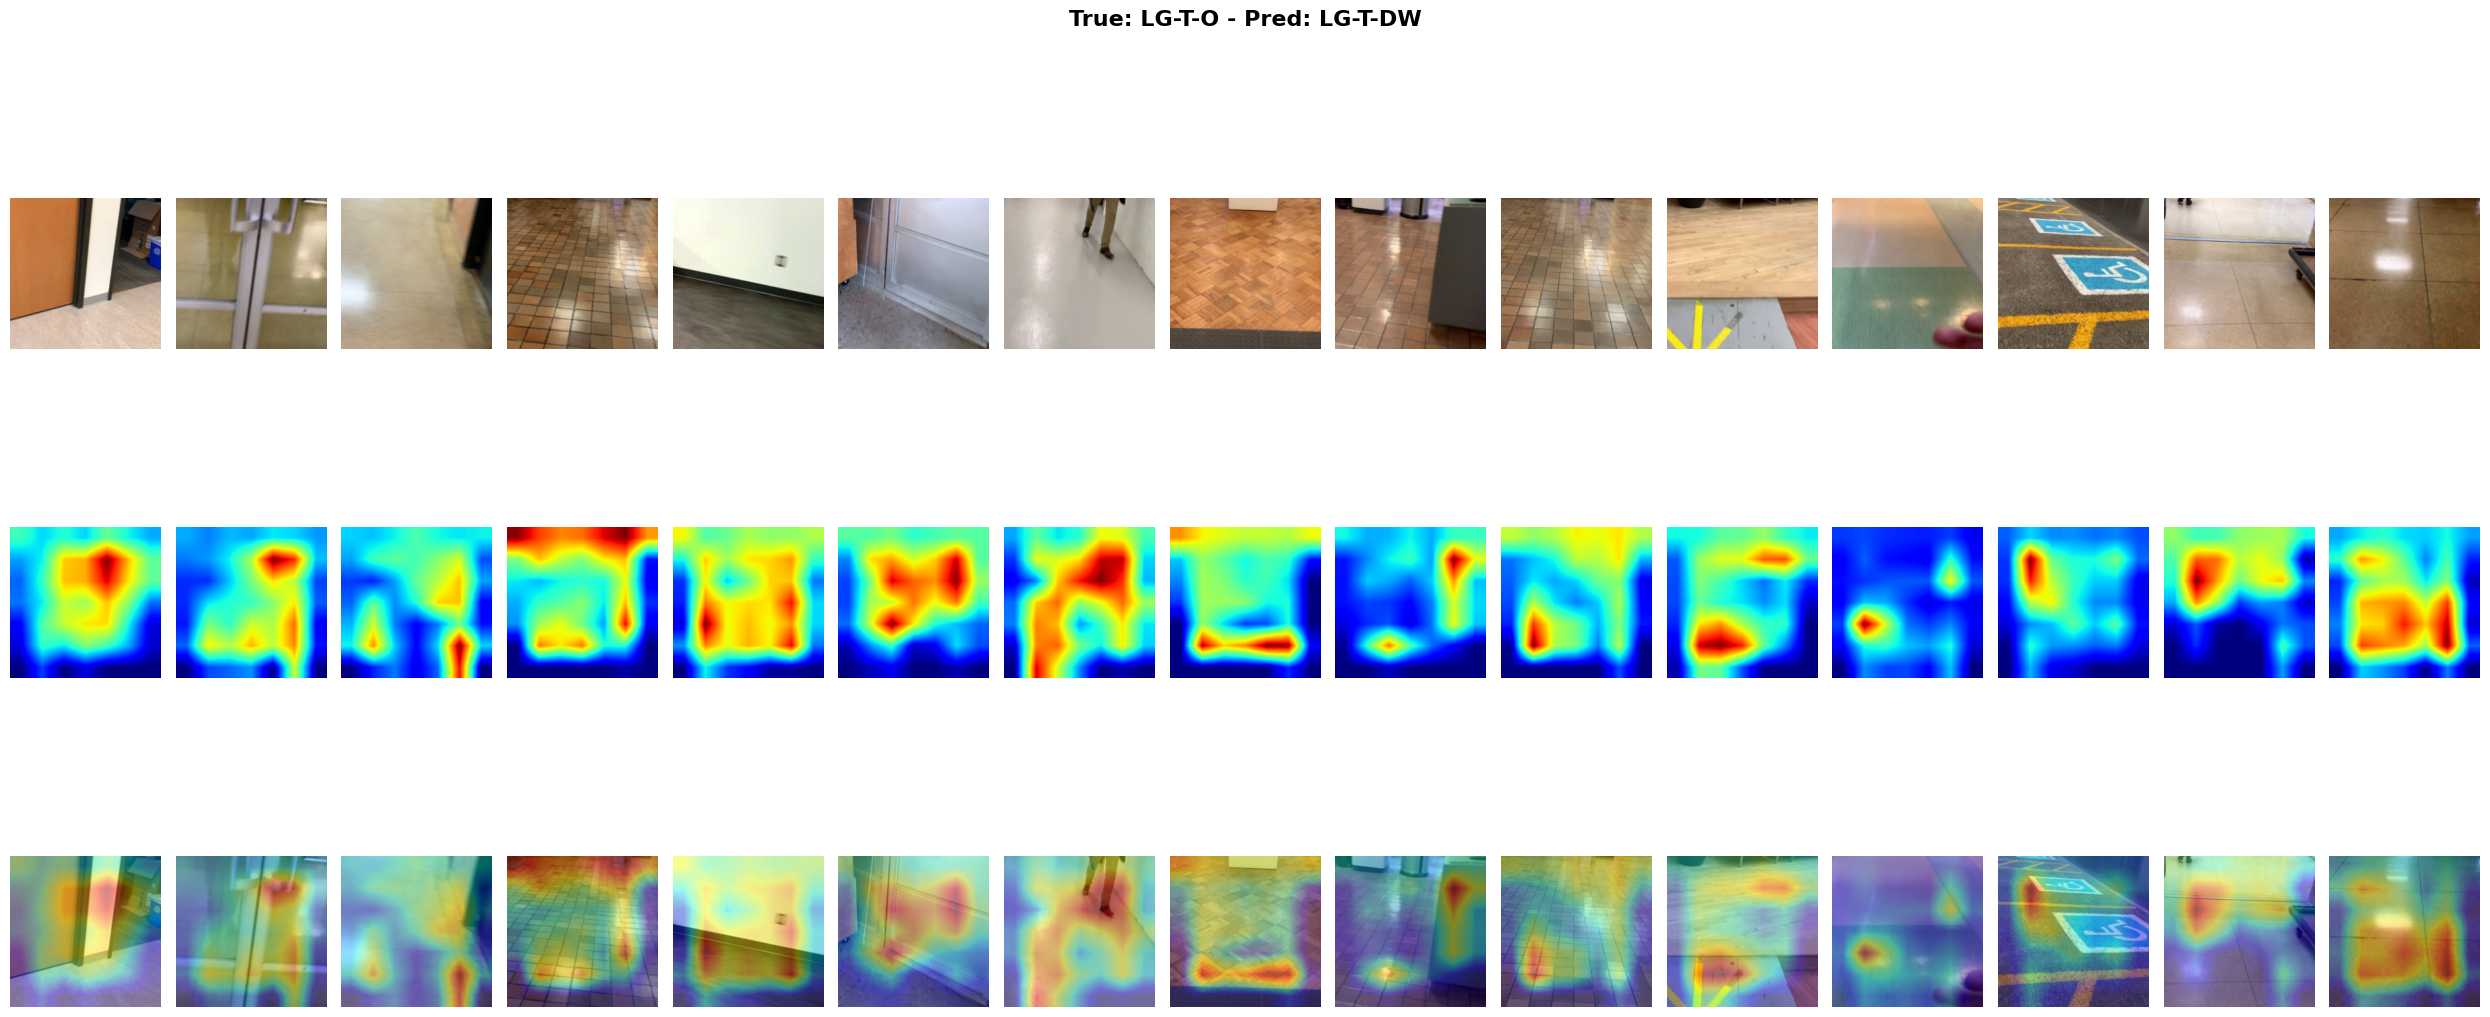

In [9]:
labels_to_inspect = [
    ('LG-T-O', 'LG-T-DW')
]

inspect_images(
    true_pred_labels=labels_to_inspect,
    n_images=15,
    trues=labels,
    preds=preds,
    label_encoder=label_encoder,
    dataset=test_dataset,
    model=transfer_best_model,
    target_layers=[transfer_best_model.backbone[7][-1].conv3]
)

# LSTM for classification
Use embeddings learnt from SwAV and classify each frame considering temporality.

In [10]:
class BackboneLSTM(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        num_layers,
        num_classes,
        dropout=0.3
    ):
        super().__init__()
        # allow hyperparameters loading when the model is loaded from a checkpoint
        self.save_hyperparameters()
        # define LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout
        )

        # define classification Head
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        # define criterion
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x, h_prev=None, c_prev=None):
        if h_prev is None:
            output, (h_n, c_n) = self.lstm(x)
        else:
            output, (h_n, c_n) = self.lstm(x, (h_prev, c_prev))
        
        return self.fc(output[:,-1,:]), h_n, c_n

    def training_step(self, batch, batch_idx):
        x, labels = batch
        # x: [batch_size, seq_len, embedding_dim]
        logits, h_n, c_n = self.forward(x)

        loss = self.criterion(logits, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=1e-3,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=MAX_EPOCHS,
            eta_min=1e-6
        )
        return [optimizer], [scheduler]
        

In [11]:
def train_lstm_model(
    model,
    dataframe,
    seq_len,
    target_transform,
    checkpoints_dir,
    checkpoint_filename
):
    # define the dataset
    dataset = FeSequenceExonetDataset(
        df=dataframe,
        seq_len=seq_len,
        target_transform=target_transform
    )

    # define dataloader
    dataloader = get_train_dataloaders(dataset)

    # define checkpoint callback
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=checkpoints_dir,
        filename=checkpoint_filename + "_{epoch:02d}",
        save_top_k=1,
        monitor="train_loss",
        mode="min",
        save_last=True,
        every_n_epochs=1
    )
    
    # define trainer
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        accelerator="gpu",
        devices=1,
        precision="16-mixed",
        callbacks=[checkpoint_callback],
        log_every_n_steps=10
    )

    # Check if the file exists before trying to load it
    checkpoint_last_file = f"{checkpoints_dir}/last.ckpt"
    if os.path.exists(checkpoint_last_file):
        print("Crash detected! Resuming from last checkpoint...")
        resume_path = checkpoint_last_file
    else:
        print("No checkpoint found. Starting fresh training...")
        resume_path = None
    
    trainer.fit(model=model, train_dataloaders=dataloader, ckpt_path=resume_path)
    print(f"Training Complete. Model saved in '{checkpoints_dir}'")

    return trainer, checkpoint_callback.best_model_path

In [12]:
# define params for training
seq_val_df = pd.read_pickle('pickle/seq_val_df.pkl')
sequence_length = 18 # 3 seconds approx. 6 frames = 1 second
hidden_dim = 512
num_layers = 1
classes = 12

# define model
lstm_resnet50_features = BackboneLSTM(
    input_dim=NUM_FTRS,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_classes=classes
)

/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [15]:
lstm_trainer, lstm_best_path = train_lstm_model(
    model=lstm_resnet50_features,
    dataframe=seq_val_df,
    seq_len=NUM_FTRS,
    target_transform=target_transform,
    checkpoints_dir='checkpoints_val_feature_lstm/',
    checkpoint_filename='lstm_resnet_50_features'
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precisio

Crash detected! Resuming from last checkpoint...


`Trainer.fit` stopped: `max_epochs=100` reached.


Training Complete. Model saved in 'checkpoints_val_feature_lstm/'


In [11]:
# read test sequence
seq_test_df = pd.read_pickle('pickle/seq_test_df.pkl')

# convert images to embeddings using test data
test_dataset = FeSequenceExonetDataset(
    df=seq_test_df,
    seq_len=1,
    target_transform=target_transform,
)


# define test dataloader
test_dataloader = get_test_val_dataloader(
    dataset=test_dataset,
    batch_size=1,
    num_workers=1
)


In [40]:
# save features to disk
save_features_to_disk(transfer_best_model.backbone, test_dataloader, '/home/luchocode/projects/tesis/data/selected_exoimages/features/test')


Generate/Store features: 100%|█████████████████████████████████████████| 753/753 [01:01<00:00, 12.24batch/s]


Evaluation: 100%|██████████████████████████████████████████████████████████████████████████| 96260/96260 [02:10<00:00, 737.53batch/s]


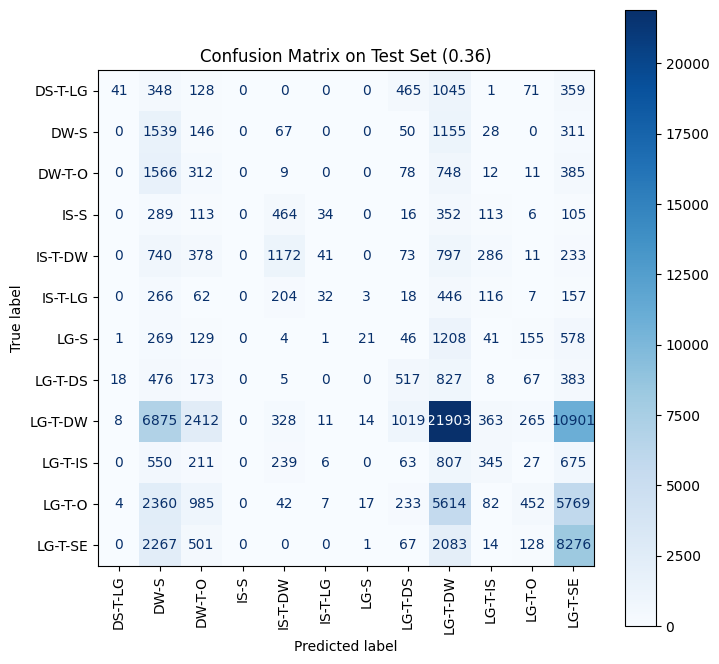

In [20]:
# best ltsm model
lstm_best_model = BackboneLSTM.load_from_checkpoint(lstm_best_path)

# show confusion matrix for test dataset
preds, labels = evaluate_cnn_model(
    model=lstm_best_model,
    loader=test_dataloader,
    device=lstm_best_model.device,
    class_names=label_encoder.classes_,
    title="Test",
    lstm=True
)

# Generate videos
It seems like model is able to group consecutive frames from a unique video. Now, videos are recreating for checking what regions the model is looking at displaying the current frame, its heatmap and an overlayed frame between them.


In [11]:
# wrapper for the model to being passed to grad-cam 
class SwAVGradCAMWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.device = self.model.device
        
    def forward(self, x):
        # f(x) -> backbone -> projection -> normalize
        features = self.model(x) 
        # Multiply by prototypes to get the scores (logits)
        # We use current_epoch=0 as a dummy value for the prototypes call
        logits = self.model.prototypes(features, step=0)
        return logits

In [15]:
# load test dataframe
df_test = pd.read_pickle('pickle/df_test.pkl')
df_test.info()

# obtain unique video names from 'video' column
video_names = df_test["video"].unique()
print(f"\nVideo names: {', '.join(video_names)}")

# select video that contains fewer frames
print(df_test.groupby(by=["video"])["frame"].count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96260 entries, 0 to 96259
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   video   96260 non-null  object
 1   frame   96260 non-null  int64 
 2   class   96260 non-null  object
 3   exist   96260 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 2.3+ MB

Video names: IMG_27_2, IMG_26_2, IMG_23_2, IMG_15_2, IMG_25_1, IMG_14_1
video
IMG_14_1     1881
IMG_15_2    16499
IMG_23_2    19625
IMG_25_1    17534
IMG_26_2    18026
IMG_27_2    22695
Name: frame, dtype: int64


In [32]:
# Filter frames based on the target video name
target_video_name = "IMG_14_1"
df_target_video = df_test[df_test["video"] == target_video_name]

# initialize swav wrapper and the target layers to get activation maps
# swav_wrapper_model = SwAVGradCAMWrapper(model=transfer_best_model)
target_layers=[transfer_best_model.backbone[7][-1].conv3]

# recreate video
recreate_video(
    model=transfer_best_model,
    df_video=df_target_video,
    img_dir=TEST_DATASET_PATH,
    output_video_name=target_video_name,
    target_layers=target_layers,
    batchsize=BATCH_SIZE,
    fps=6,
    num_workers=NUM_WORKERS
)

Video generation: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:21<00:00,  1.45s/batch]

Combined video saved successfully!
